In [1]:
!pip install pandas
!pip install sentence-transformers
!pip install umap-learn
!pip install bertopic
!pip install nbformat
!pip install ipykernel
!pip install --upgrade nbformat



In [2]:
import pandas as pd
import sentence_transformers
from sentence_transformers import SentenceTransformer
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

c:\Users\jiyon\Desktop\Programming_projects\UNSW\LLM-reviewtransformation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
# set sns plot 
sns.set_theme()
sns.set_theme(style="whitegrid")
sns.set_context("talk")
plt.rcParams.update({'font.size': 14}) 
plt.rcParams['axes.facecolor'] = 'white'    # Plot area background
plt.rcParams['figure.facecolor'] = 'white'  # Outside plot area (whole figure)

In [4]:
df = pd.read_csv("../../Dataset/tweets/transformed_final.csv")
df = df.rename(columns={"batch": "Batch"})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
clean_embs = model.encode(df['cleaned_transform'].tolist())
groq_embs = model.encode(df['transformed_tweets_groq'].tolist())
gemini_embs = model.encode(df['transformed_tweets_gemini'].tolist())
gpt_embs = model.encode(df['transformed_tweets_gpt'].tolist())
deepseek_embs = model.encode(df['transformed_tweets_deepseek'].tolist())

model_outputs = {
    "Original": (df["cleaned_transform"].tolist(), clean_embs),
    "Groq": (df["transformed_tweets_groq"].tolist(), groq_embs),
    "GPT": (df["transformed_tweets_gpt"].tolist(), gpt_embs),
    "Gemini": (df["transformed_tweets_gemini"].tolist(), gemini_embs),
    "DeepSeek": (df["transformed_tweets_deepseek"].tolist(), deepseek_embs)
}


In [6]:
model_outputs

{'Original': (['if you bother to do the maths then in actual fact the socalled reformers of islam have literally not one single mi',
   'muslims be like the quran is true it says so in the quran',
   'that painting by jim carrey of sharia huckabaloney is a spittin image of her a person who daily dishes out balone',
   'so i say fck islam it should be banned in the uk as it goes against all our beliefs its against womens rights a',
   'theresa may has her head so far up the muslamic ass that she doesnt need a sun tan youtube comment i just read',
   'a new muslamic dating app has been launched',
   'its not racist to criticise the teachings of islam to burst your bubble again',
   'i like it when the fox calling her law advocate fox news is sooo foxy',
   'or ever organize a protest against sharia',
   'my favorite word in the english language is because when i hear it i know you finally done asking me for stupid shit',
   'it has finally happened swedish court has followed sharia law f

In [7]:
data = []
versions = ['Orig', 'Groq', 'GPT', 'Gem', 'DS']
all_embs = {
    'Orig': clean_embs,
    'Groq': groq_embs,
    'GPT': gpt_embs,
    'Gem': gemini_embs,
    'DS': deepseek_embs,

}

# cosine similairty for all possible combinations
for i in range(len(df)):
    row = {'Batch': df['Batch'][i]}
    for v1, v2 in combinations(versions, 2):
        sim = cosine_similarity([all_embs[v1][i]], [all_embs[v2][i]])[0][0]
        row[f'{v1} vs {v2}'] = sim
    data.append(row)


In [8]:
semantic_df = pd.DataFrame(data)

In [9]:
semantic_df

,Batch,Orig vs Groq,Orig vs GPT,Orig vs Gem,Orig vs DS,Groq vs GPT,Groq vs Gem,Groq vs DS,GPT vs Gem,GPT vs DS,Gem vs DS
0,1,0.586812,0.618557,0.621310,0.601447,0.848012,0.574727,0.736910,0.640047,0.847292,0.697336
1,1,0.383714,0.626996,0.543842,0.588157,0.637355,0.514002,0.631639,0.695270,0.967343,0.683968
2,1,0.509619,0.578746,0.602767,0.694710,0.703136,0.696615,0.787204,0.738665,0.874023,0.819371
3,1,0.518724,0.558992,0.707070,0.611048,0.791903,0.580149,0.799937,0.692040,0.870538,0.703375
4,1,0.427090,0.603940,0.405413,0.596159,0.668931,0.436037,0.699158,0.479846,0.903807,0.521278
...,...,...,...,...,...,...,...,...,...,...,...
395,20,0.586521,0.724633,0.658230,0.694058,0.795705,0.706056,0.836440,0.734437,0.838809,0.855950
396,20,0.574353,0.798330,0.628526,0.717690,0.702934,0.705845,0.743631,0.735851,0.879118,0.805187
397,20,0.788065,0.833329,0.823366,0.836354,0.848971,0.808909,0.890102,0.841906,0.969833,0.867972
398,20,0.851801,0.847862,0.851893,0.841348,0.984293,0.884254,0.973286,0.901220,0.978178,0.879657


Semantic Analysis

In [10]:
# group by mean, std
grouped = semantic_df.groupby('Batch').agg(['mean', 'std'])

# combine into one
formatted = pd.DataFrame(index=grouped.index)

for col in grouped.columns.levels[0]:
    mean_col = grouped[col]['mean']
    std_col = grouped[col]['std']
    formatted[col] = mean_col.round(3).astype(str) + ' (' + std_col.round(3).astype(str) + ')'


formatted.reset_index(inplace=True)


In [11]:
latex_table = formatted.to_latex(index=False, escape=False, )
latex_table

'\\begin{tabular}{rllllllllll}\n\\toprule\nBatch & Orig vs Groq & Orig vs GPT & Orig vs Gem & Orig vs DS & Groq vs GPT & Groq vs Gem & Groq vs DS & GPT vs Gem & GPT vs DS & Gem vs DS \\\\\n\\midrule\n1 & 0.501 (0.187) & 0.605 (0.151) & 0.586 (0.193) & 0.609 (0.179) & 0.714 (0.18) & 0.535 (0.197) & 0.724 (0.166) & 0.625 (0.153) & 0.816 (0.121) & 0.642 (0.18) \\\\\n2 & 0.513 (0.213) & 0.614 (0.169) & 0.625 (0.123) & 0.619 (0.189) & 0.673 (0.202) & 0.563 (0.167) & 0.694 (0.194) & 0.58 (0.11) & 0.811 (0.119) & 0.617 (0.124) \\\\\n3 & 0.542 (0.186) & 0.592 (0.162) & 0.552 (0.189) & 0.55 (0.183) & 0.741 (0.113) & 0.582 (0.158) & 0.752 (0.099) & 0.586 (0.151) & 0.829 (0.122) & 0.548 (0.168) \\\\\n4 & 0.507 (0.131) & 0.592 (0.134) & 0.615 (0.126) & 0.588 (0.17) & 0.755 (0.101) & 0.601 (0.141) & 0.781 (0.095) & 0.64 (0.118) & 0.832 (0.121) & 0.611 (0.153) \\\\\n5 & 0.522 (0.166) & 0.623 (0.151) & 0.566 (0.193) & 0.606 (0.15) & 0.701 (0.17) & 0.534 (0.206) & 0.705 (0.179) & 0.584 (0.2) & 0.836 (

In [12]:
formatted.to_csv("../../Plots/measurements.csv")

In [13]:
semantic_long = pd.melt(semantic_df, id_vars="Batch", var_name="Comparison", value_name="Similarity")

In [14]:
semantic_long

,Batch,Comparison,Similarity
0,1,Orig vs Groq,0.586812
1,1,Orig vs Groq,0.383714
2,1,Orig vs Groq,0.509619
3,1,Orig vs Groq,0.518724
4,1,Orig vs Groq,0.427090
...,...,...,...
3995,20,Gem vs DS,0.855950
3996,20,Gem vs DS,0.805187
3997,20,Gem vs DS,0.867972
3998,20,Gem vs DS,0.879657


In [15]:
original = semantic_long[semantic_long['Comparison'].str.contains("Orig")]
other = semantic_long[~semantic_long['Comparison'].str.contains("Orig")]

C:\Users\jiyon\AppData\Local\Temp\ipykernel_18248\2565027867.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(original, x="Batch", y="Similarity", hue="Comparison", ci=None)


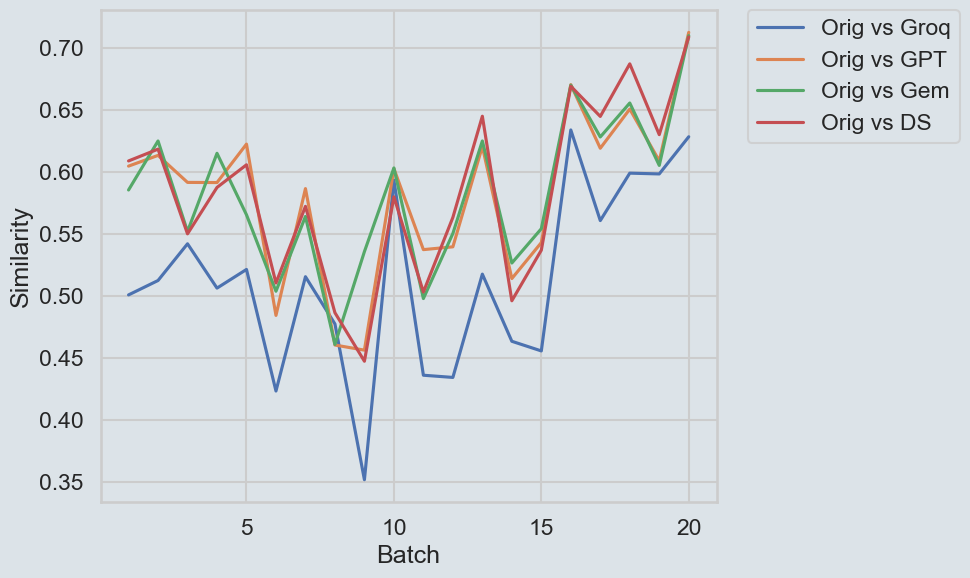

In [29]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(original, x="Batch", y="Similarity", hue="Comparison", ci=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()  
plt.show()

C:\Users\jiyon\AppData\Local\Temp\ipykernel_18248\1060419101.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(other, x="Batch", y="Similarity", hue="Comparison", ci=None)


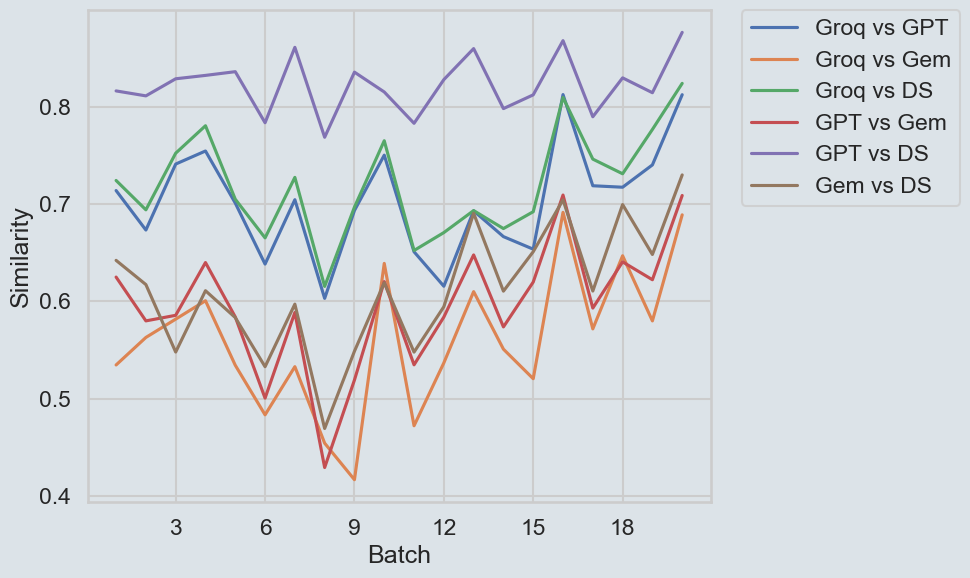

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(other, x="Batch", y="Similarity", hue="Comparison", ci=None)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout() 
plt.show()

In [18]:
semantic_long

,Batch,Comparison,Similarity
0,1,Orig vs Groq,0.586812
1,1,Orig vs Groq,0.383714
2,1,Orig vs Groq,0.509619
3,1,Orig vs Groq,0.518724
4,1,Orig vs Groq,0.427090
...,...,...,...
3995,20,Gem vs DS,0.855950
3996,20,Gem vs DS,0.805187
3997,20,Gem vs DS,0.867972
3998,20,Gem vs DS,0.879657


In [19]:
semantic_long = semantic_long.sort_values(ascending=True, by="Comparison")

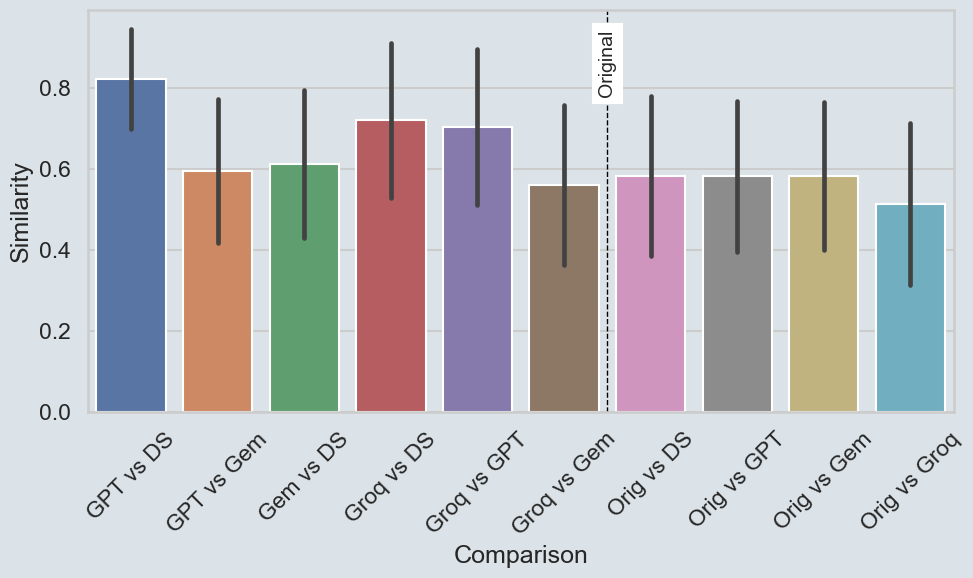

In [20]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=semantic_long, 
    x="Comparison", 
    y="Similarity", 
    hue="Comparison", 
    errorbar="sd", 
    dodge=False  
)



# add vertical line
ax.axvline(x=5.5, color='black', linestyle='--', linewidth=1)  # x=5.5 is between 6th and 7th bar (0-based index)

# add text
plt.text(5.5, plt.ylim()[1] * 0.95, 'Original', 
         ha='center', va='top', rotation=90, backgroundcolor='white')


plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [21]:
semantic_df

,Batch,Orig vs Groq,Orig vs GPT,Orig vs Gem,Orig vs DS,Groq vs GPT,Groq vs Gem,Groq vs DS,GPT vs Gem,GPT vs DS,Gem vs DS
0,1,0.586812,0.618557,0.621310,0.601447,0.848012,0.574727,0.736910,0.640047,0.847292,0.697336
1,1,0.383714,0.626996,0.543842,0.588157,0.637355,0.514002,0.631639,0.695270,0.967343,0.683968
2,1,0.509619,0.578746,0.602767,0.694710,0.703136,0.696615,0.787204,0.738665,0.874023,0.819371
3,1,0.518724,0.558992,0.707070,0.611048,0.791903,0.580149,0.799937,0.692040,0.870538,0.703375
4,1,0.427090,0.603940,0.405413,0.596159,0.668931,0.436037,0.699158,0.479846,0.903807,0.521278
...,...,...,...,...,...,...,...,...,...,...,...
395,20,0.586521,0.724633,0.658230,0.694058,0.795705,0.706056,0.836440,0.734437,0.838809,0.855950
396,20,0.574353,0.798330,0.628526,0.717690,0.702934,0.705845,0.743631,0.735851,0.879118,0.805187
397,20,0.788065,0.833329,0.823366,0.836354,0.848971,0.808909,0.890102,0.841906,0.969833,0.867972
398,20,0.851801,0.847862,0.851893,0.841348,0.984293,0.884254,0.973286,0.901220,0.978178,0.879657


In [22]:
comparisons = semantic_df.drop(columns="Batch")
means = comparisons.mean().round(3)
stds = comparisons.std().round(3)
print(means)
print(stds)

Orig vs Groq    0.514
Orig vs GPT     0.582
Orig vs Gem     0.582
Orig vs DS      0.583
Groq vs GPT     0.703
Groq vs Gem     0.560
Groq vs DS      0.720
GPT vs Gem      0.595
GPT vs DS       0.823
Gem vs DS       0.613
dtype: float32
Orig vs Groq    0.200
Orig vs GPT     0.187
Orig vs Gem     0.183
Orig vs DS      0.197
Groq vs GPT     0.193
Groq vs Gem     0.197
Groq vs DS      0.191
GPT vs Gem      0.178
GPT vs DS       0.123
Gem vs DS       0.183
dtype: float32


In [23]:
rows = []
for model_name, embeddings in all_embs.items():
    for i, emb in enumerate(embeddings):
        rows.append({
            'batch': i,
            'model': model_name,
            'embedding': emb
        })


df_embs = pd.DataFrame(rows)
# stack together
emb_array = np.vstack(df_embs['embedding'].values) 
emb_df = pd.DataFrame(emb_array, columns=[f'dim_{i}' for i in range(emb_array.shape[1])])



In [24]:
df_embs

,batch,model,embedding
0,0,Orig,"[-0.037697844, -0.025611673, -0.0060677277, -0..."
1,1,Orig,"[0.05442989, 0.005573005, 0.014092423, -0.0159..."
2,2,Orig,"[0.03023139, 0.074154384, -0.012508403, -0.001..."
3,3,Orig,"[-0.022994034, 0.01440142, 0.00840599, 0.00480..."
4,4,Orig,"[-0.011766515, 0.024291381, 0.00078020076, -0...."
...,...,...,...
1995,395,DS,"[0.055408016, 0.07320115, 0.0015605988, 0.0430..."
1996,396,DS,"[0.018758195, 0.08574585, -0.0061674914, -0.01..."
1997,397,DS,"[-0.01644467, 0.11668765, 0.028108152, -0.0011..."
1998,398,DS,"[0.027419923, 0.056523018, -0.008913566, 0.041..."


In [25]:
emb_array

array([[-0.03769784, -0.02561167, -0.00606773, ...,  0.00105824,
         0.00153819,  0.0022844 ],
       [ 0.05442989,  0.005573  ,  0.01409242, ..., -0.01589041,
         0.04202234, -0.03802771],
       [ 0.03023139,  0.07415438, -0.0125084 , ..., -0.02168244,
        -0.03579484, -0.03444018],
       ...,
       [-0.01644467,  0.11668765,  0.02810815, ...,  0.04289521,
        -0.08183977,  0.02333216],
       [ 0.02741992,  0.05652302, -0.00891357, ...,  0.01409639,
         0.03543568, -0.02389295],
       [ 0.04739507, -0.00910918, -0.00202207, ...,  0.03303381,
        -0.02020888, -0.02727645]], shape=(2000, 768), dtype=float32)

In [26]:
emb_df

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_758,dim_759,dim_760,dim_761,dim_762,dim_763,dim_764,dim_765,dim_766,dim_767
0,-0.037698,-0.025612,-0.006068,-0.012583,-0.043684,0.009731,0.072474,-0.016563,0.008406,0.018894,...,-0.002317,0.017066,0.001029,0.027745,-0.006859,-0.054434,0.004385,0.001058,0.001538,0.002284
1,0.054430,0.005573,0.014092,-0.015948,-0.052359,0.015184,0.029534,0.008037,-0.040867,0.000364,...,-0.001009,0.015071,-0.013012,-0.004968,-0.004884,0.007130,0.042996,-0.015890,0.042022,-0.038028
2,0.030231,0.074154,-0.012508,-0.001534,-0.041149,0.064024,0.025404,0.025417,0.046546,0.016978,...,-0.014737,0.071352,0.011899,-0.020535,-0.018791,-0.041160,-0.006128,-0.021682,-0.035795,-0.034440
3,-0.022994,0.014401,0.008406,0.004807,-0.052965,0.045664,0.050944,-0.032005,0.052582,0.013904,...,-0.018963,0.019709,0.045775,-0.036437,-0.012722,-0.016921,0.019363,0.017042,-0.024432,0.030440
4,-0.011767,0.024291,0.000780,-0.038392,0.004186,0.020650,0.031552,-0.008352,0.035285,0.027966,...,-0.010874,0.020087,0.020614,-0.067253,-0.012083,-0.031762,0.010930,-0.002616,-0.054534,0.009840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.055408,0.073201,0.001561,0.043079,-0.034740,0.036118,0.018688,-0.018413,-0.000839,0.008663,...,-0.026901,0.008316,-0.014322,0.051552,-0.020506,-0.067240,-0.019379,0.009445,0.066252,0.026766
1996,0.018758,0.085746,-0.006167,-0.012517,-0.006818,0.039896,-0.037285,0.015616,0.022274,-0.057424,...,0.005793,0.072796,0.043469,-0.047665,-0.024572,0.016733,-0.076992,-0.053938,-0.010475,-0.027746
1997,-0.016445,0.116688,0.028108,-0.001191,-0.030996,0.014284,0.080041,-0.001890,0.065821,0.023241,...,-0.043971,0.026033,-0.002928,0.034184,-0.023556,-0.102087,-0.055058,0.042895,-0.081840,0.023332
1998,0.027420,0.056523,-0.008914,0.041570,0.026770,0.023458,0.068237,-0.035204,-0.012560,-0.013301,...,0.021275,0.038176,0.017272,-0.000290,-0.021409,-0.026427,-0.023537,0.014096,0.035436,-0.023893


In [27]:
import umap.umap_ as umap

reducer = umap.UMAP(
    n_neighbors=10,       
    min_dist=0.1,         
    n_components=2,       
    metric='cosine',      
    random_state=42       
)

embedding = reducer.fit_transform(emb_array)
embedding.shape


c:\Users\jiyon\Desktop\Programming_projects\UNSW\LLM-reviewtransformation\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jiyon\Desktop\Programming_projects\UNSW\LLM-reviewtransformation\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(2000, 2)

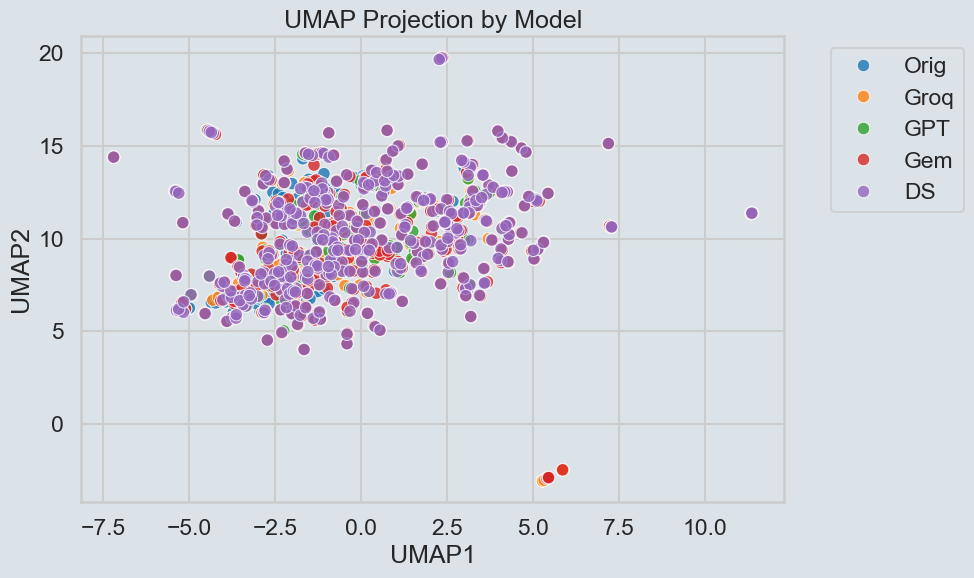

In [28]:
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_df['model'] = df_embs['model'].values  # or 'batch' if preferred
# plot

plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='model', palette='tab10', alpha=0.8)
plt.title('UMAP Projection by Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()